# Inference of mutational signatures using Gibbs sampling
---

# Setup

In [1]:
import pandas as pd
import arviz as az
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from time import time
from utils import *

In [2]:
path = "../../../results/NikZainal-breast_cancer_spectra.csv"
counts = pd.pivot(pd.read_csv(path, sep="\t"), "sample", "substitution_type", "count").fillna(0).astype(int)

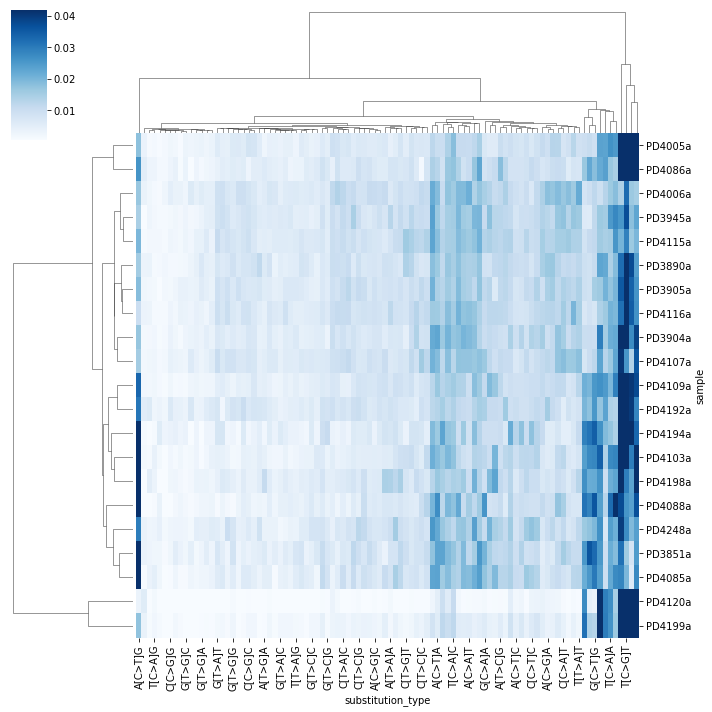

In [3]:
sns.clustermap(counts.div(counts.sum(axis=1), axis=0), robust=True, cmap="Blues")

# Sampling

In [4]:
start = time()
set_srng(seed=1234)
mcmc_results = sample_full_model(counts, mcmc_steps=100000)
mcmc_time = time() - start

In [5]:
print(f"MCMC time: {mcmc_time:.1f}s")

MCMC time: 1304.3s


In [6]:
az.to_netcdf(mcmc_results, "../../../results/signeR-replication/full_model.netcdf")

'../../../results/signeR-replication/full_model.netcdf'

In [7]:
mcmc_results = az.from_netcdf("../../../results/signeR-replication/full_model.netcdf")

# Effective sample size

In [8]:
ess = az.ess(mcmc_results)

In [9]:
ess.median()

<xarray.Dataset>
Dimensions:           ()
Data variables:
    exposure          float64 78.55
    signature         float64 467.5
    alpha_exposure    float64 1e+05
    alpha_signature   float64 1e+05
    lambda_exposure   float64 1.006e+05
    lambda_signature  float64 9.895e+04

In [10]:
ess.min()

<xarray.Dataset>
Dimensions:           ()
Data variables:
    exposure          float64 13.69
    signature         float64 15.97
    alpha_exposure    float64 1e+05
    alpha_signature   float64 1e+05
    lambda_exposure   float64 1.006e+05
    lambda_signature  float64 9.895e+04

In [11]:
ess.max()

<xarray.Dataset>
Dimensions:           ()
Data variables:
    exposure          float64 1.071e+03
    signature         float64 1.992e+04
    alpha_exposure    float64 1e+05
    alpha_signature   float64 1e+05
    lambda_exposure   float64 1.006e+05
    lambda_signature  float64 9.895e+04

In [12]:
ess.median()/mcmc_time

<xarray.Dataset>
Dimensions:           ()
Data variables:
    exposure          float64 0.06022
    signature         float64 0.3584
    alpha_exposure    float64 76.67
    alpha_signature   float64 76.67
    lambda_exposure   float64 77.11
    lambda_signature  float64 75.86

In [13]:
ess.min()/mcmc_time

<xarray.Dataset>
Dimensions:           ()
Data variables:
    exposure          float64 0.0105
    signature         float64 0.01225
    alpha_exposure    float64 76.67
    alpha_signature   float64 76.67
    lambda_exposure   float64 77.11
    lambda_signature  float64 75.86

In [14]:
ess.max()/mcmc_time

<xarray.Dataset>
Dimensions:           ()
Data variables:
    exposure          float64 0.8211
    signature         float64 15.27
    alpha_exposure    float64 76.67
    alpha_signature   float64 76.67
    lambda_exposure   float64 77.11
    lambda_signature  float64 75.86

# Signature visualization

In [15]:
plot_data = mcmc_results.posterior.signature.to_series().reset_index()
plot_data["substitution_without_context"] = plot_data.substitution.str[2:-2]

In [16]:
sub_types = mcmc_results.posterior.substitution.to_series()
sub_types = (sub_types.str[2]+sub_types.str[4]+sub_types.str[0]+sub_types.str[-1]).sort_values().index

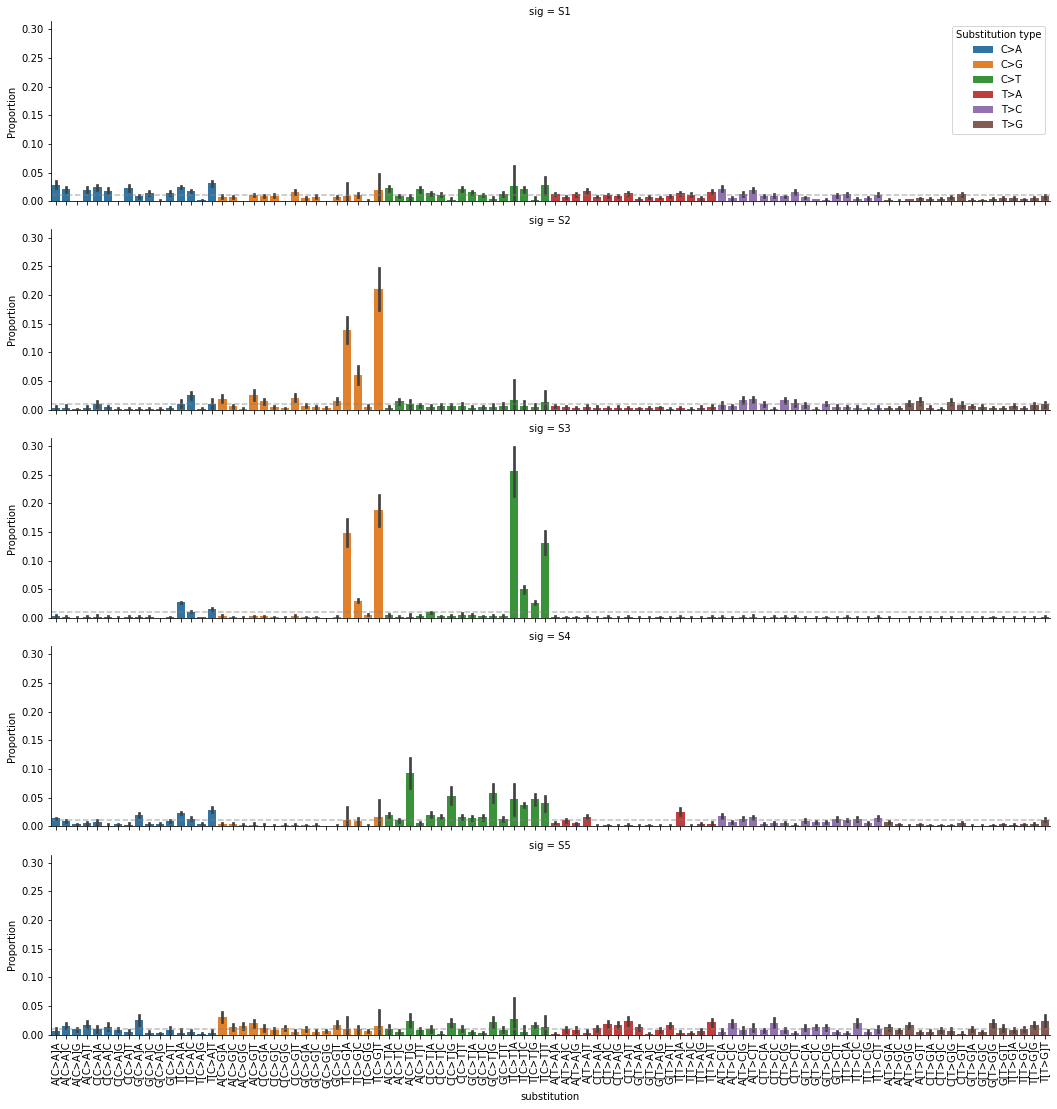

In [17]:
g = sns.catplot(
    data = plot_data[plot_data["draw"] % 10000 == 0], x="substitution", y="signature", ci="sd", hue="substitution_without_context", kind="bar", row="sig",
    order = sub_types, dodge=False, aspect=5, legend_out=False, height=3)
plt.xticks(rotation=90)
[ax.axhline(1/96, ls= "--", c="gray", alpha=0.5) for ax in g.axes.flat]
g.axes.flat[0].get_legend().set_title("Substitution type")
g.set(ylim=(0, None), ylabel="Proportion")

# Signature exposures

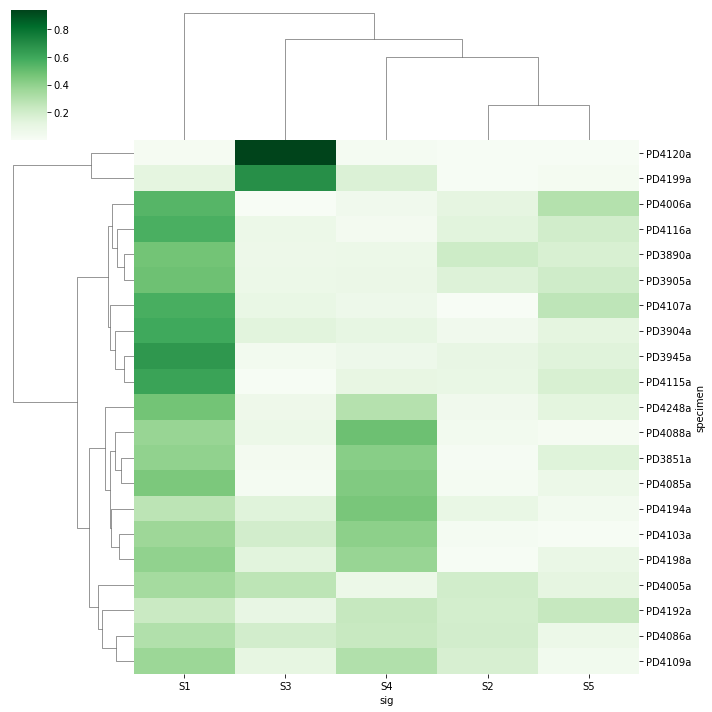

In [18]:
expected_exposures = mcmc_results.posterior.mean(["chain","draw"]).exposure.to_pandas()
sns.clustermap(expected_exposures, cmap="Greens")

# Comparison to COSMIC signatures

In [19]:
cosmic_sigs = pd.read_csv("../../../resources/COSMIC_v3.2_SBS_GRCh37.txt", sep="\t", index_col="Type")
cosmic_sigs = cosmic_sigs.loc[mcmc_results.posterior.substitution.values]
cosmic_sigs.index.name = "substitution"
cosmic_sigs.columns.name = "cosmic_sig"
cosmic_sigs = cosmic_sigs.unstack().to_xarray()

In [20]:
thinned_mcmc_signatures = mcmc_results.posterior.where(mcmc_results.posterior.draw % 100 == 0, drop=True).signature
dot_products = (thinned_mcmc_signatures * cosmic_sigs).sum("substitution")
norm_breast_sig = np.sqrt((thinned_mcmc_signatures ** 2).sum("substitution"))
norm_cosmic_sig = np.sqrt((cosmic_sigs ** 2).sum("substitution"))

cosine_sim = dot_products/norm_breast_sig/norm_cosmic_sig

In [21]:
(
    cosine_sim
        .mean(["draw", "chain"])
        .to_pandas()
        .reset_index()
        .melt(value_name="similarity",id_vars=["sig"])
        .sort_values(by="similarity", ascending=False)
        .head(10)
        .reset_index(drop=True)
)

,sig,cosmic_sig,similarity
0,S2,SBS13,0.929973
1,S1,SBS40,0.911098
2,S1,SBS3,0.866058
3,S4,SBS1,0.794596
4,S1,SBS5,0.790538
5,S1,SBS8,0.786088
6,S3,SBS2,0.773056
7,S1,SBS89,0.769694
8,S1,SBS94,0.763478
9,S4,SBS6,0.739867


## Is S4 driven by spontaneous deamination?

In [22]:
CpG = mcmc_results.posterior.substitution.str.contains("\[C>T\]G")
S4_CpG_proportion = (
    mcmc_results.posterior
    .signature
    .sel(sig="S4", substitution=CpG)
    .sum("substitution")
    .values
    .flatten()
)

In [23]:
C2T = mcmc_results.posterior.substitution.str.contains("\[C>T\]")
S4_C2T_proportion = (
    mcmc_results.posterior
    .signature
    .sel(sig="S4", substitution=C2T)
    .sum("substitution")
    .values
    .flatten()
)

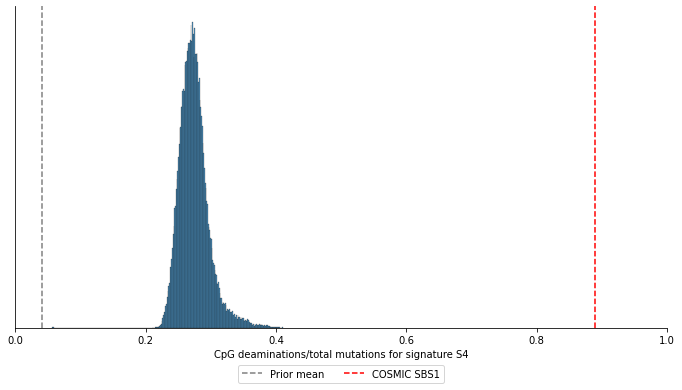

In [24]:
sns.displot(S4_CpG_proportion, aspect=2)
plt.axvline(4/96, ls="--", c="gray", label="Prior mean")
plt.axvline(cosmic_sigs.sel(cosmic_sig="SBS1").where(cosmic_sigs.substitution.str.contains("\[C>T\]G"), drop=True).sum().values,
            ls="--", c="r", label="COSMIC SBS1")
plt.xlim(0,1)
plt.yticks([])
plt.ylabel("")
plt.xlabel("CpG deaminations/total mutations for signature S4")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=5)

# Which signatures represent APOBEC-driven mutagenesis?

In [25]:
APOBEC = mcmc_results.posterior.substitution.str.contains("T\[C>[GT]\][AT]")
S2_APOBEC_proportion = (
    mcmc_results.posterior
    .signature
    .sel(sig="S2", substitution=APOBEC)
    .sum("substitution")
    .values
    .flatten()
)
S3_APOBEC_proportion = (
    mcmc_results.posterior
    .signature
    .sel(sig="S3", substitution=APOBEC)
    .sum("substitution")
    .values
    .flatten()
)

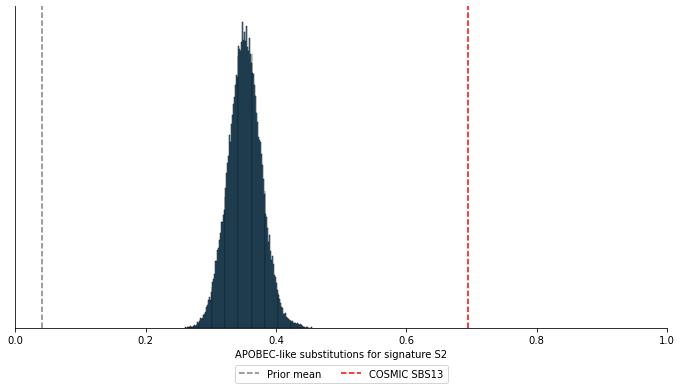

In [26]:
sns.displot(S2_APOBEC_proportion, aspect=2)
plt.axvline(4/96, ls="--", c="gray", label="Prior mean")
plt.axvline(cosmic_sigs.sel(cosmic_sig="SBS13").where(cosmic_sigs.substitution.str.contains("T\[C>[GT]\][AT]"), drop=True).sum().values,
            ls="--", c="r", label="COSMIC SBS13")
plt.xlim(0,1)
plt.yticks([])
plt.ylabel("")
plt.xlabel("APOBEC-like substitutions for signature S2")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=5)

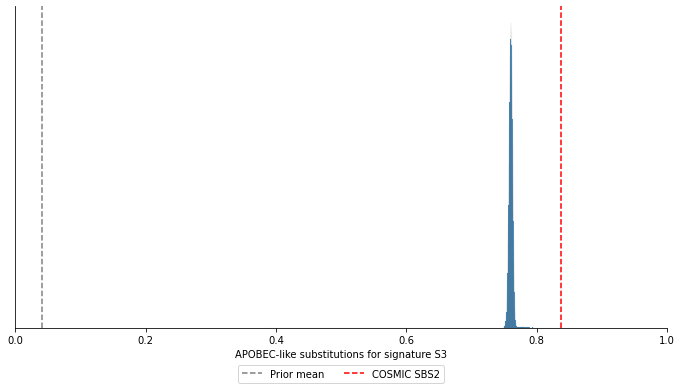

In [27]:
sns.displot(S3_APOBEC_proportion, aspect=2)
plt.axvline(4/96, ls="--", c="gray", label="Prior mean")
plt.axvline(cosmic_sigs.sel(cosmic_sig="SBS2").where(cosmic_sigs.substitution.str.contains("T\[C>[GT]\][AT]"), drop=True).sum().values,
            ls="--", c="r", label="COSMIC SBS2")
plt.xlim(0,1)
plt.yticks([])
plt.ylabel("")
plt.xlabel("APOBEC-like substitutions for signature S3")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=5)